#  0. 用matplotlib找系统中字体文件大于1MB的
> 中文字体通常很大，这样过滤出的 通常有中文字体

> 结果中 看名字  'AR PL UMing CN' 果然是中文字体

In [1]:
from matplotlib.font_manager import fontManager
import os
 
fonts = [font.name for font in fontManager.ttflist if 
         os.path.exists(font.fname) and os.stat(font.fname).st_size>1e6] 
 
for font in fonts:
    print(font)

Peddana
TenaliRamakrishna
Noto Serif CJK JP
Noto Sans CJK JP
Noto Serif Tangut
Noto Serif CJK JP
Chandas
AR PL UMing CN
Noto Serif CJK JP
Noto Sans CJK JP
Noto Sans CJK JP
Noto Sans CJK JP
Droid Sans Fallback
Noto Sans CJK JP
Noto Sans SignWriting
FreeSerif
AR PL UKai CN
Noto Serif CJK JP
Timmana
Noto Serif CJK JP
Noto Serif CJK JP
Noto Serif CJK JP
Noto Sans CJK JP
Noto Sans CJK JP
Tibetan Machine Uni


#  1. 产生tick日志

#####  编译最小main : 文件 mini_main.c
```cpp
//文件 mini_main.c
int main(int argc, char** argv){
    return 0;
}
```

```bash
tick_save=true /pubx/build-llvm15/bin/clang-15 -c mini_main.c
#生成tick日志文件:
#-rw-rw-r--  155M  8月 11 23:10 clang-15_290208_1691766635578_1


```

# 2. 加载tick日志

In [2]:
# %config InlineBackend.figure_format = 'svg'
%config InlineBackend.rc={'figure.figsize': (30,20)}

In [3]:
import numpy 
import math

In [4]:
import seaborn

In [5]:
import plotly.offline as plotly_offline
plotly_offline.init_notebook_mode(connected=True)          
import plotly.graph_objs as graph_objs                
import plotly.figure_factory as figure_factory 

from plotly.graph_objs import Scatter, Figure, Scatter3d




> 解决 matplotlib 中文不正常显示问题，
>
> 中文显示为方块，原因是没有中文字体，
>
> 这里 将字体设置为 上面找到的中文字体 'AR PL UMing CN'

In [6]:
import matplotlib.pyplot
matplotlib.pyplot.rcParams['font.family'] = 'AR PL UMing CN'
matplotlib.pyplot.rcParams['font.sans-serif'] = [ 'AR PL UMing CN']

In [7]:
import pandas
# pandas.options.display.max_columns = None
# pandas.options.display.max_rows = None

In [8]:
%%bash
ls -lhrt /tick_data_home/ | tail -n 1

-rw-rw-r-- 1 zz zz 155M  8月 11 23:10 clang-15_290208_1691766635578_1


In [9]:
#编译正常: mini_main.c
df=pandas.read_csv(filepath_or_buffer="/tick_data_home/clang-15_290208_1691766635578_1",sep=',' , quotechar="'")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001223 entries, 0 to 1001222
Data columns (total 22 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   滴答                 1001223 non-null  int64 
 1   funcLocalClock     1001223 non-null  int64 
 2   tickKind           1001223 non-null  int64 
 3   funcEnterId        1001223 non-null  int64 
 4   hasFuncCallChain   1001223 non-null  int64 
 5   funcEnterIdSeqLen  1001223 non-null  int64 
 6   funcEnterIdSeq     116419 non-null   object
 7   rTSVarC            1001223 non-null  int64 
 8   d栈生                1001223 non-null  int64 
 9   d栈死                1001223 non-null  int64 
 10  d堆生                1001223 non-null  int64 
 11  d堆死                1001223 non-null  int64 
 12  栈生                 1001223 non-null  int64 
 13  栈死                 1001223 non-null  int64 
 14  栈净                 1001223 non-null  int64 
 15  堆生                 1001223 non-null  int64 
 16  

/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning:

Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.



# 3. funcId 构造

In [10]:
df.head(1)

,滴答,funcLocalClock,tickKind,funcEnterId,hasFuncCallChain,funcEnterIdSeqLen,funcEnterIdSeq,rTSVarC,d栈生,d栈死,...,栈生,栈死,栈净,堆生,堆死,堆净,srcFile,funcLine,funcCol,funcName
0,1,1,1,0,1,1,0#'',0,0,0,...,0,0,0,0,0,0,/pubx/llvm-project/llvm/lib/Support/CommandLin...,42,42,llvm::cl::getGeneralCategory


####  3.1 新增列 funcLoc  相当于字符串样式的funId

In [11]:
#新增列 funcLoc 
df['funcLoc']=df .apply(lambda r: f'{r.srcFile}_{r.funcLine}_{r.funcCol}', axis=1 )
df['funcLoc'].values[:4]

array(['/pubx/llvm-project/llvm/lib/Support/CommandLine.cpp_42_42',
       '/pubx/llvm-project/llvm/lib/Support/CommandLine.cpp_42_42',
       '/pubx/llvm-project/llvm/lib/Support/CommandLine.cpp_41_41',
       '/pubx/llvm-project/llvm/lib/Support/CommandLine.cpp_41_41'],
      dtype=object)

####  3.2  以 区间[0, funcLoc不重复个数-1] 作为 funcId表

In [12]:

funcLoc_values=df['funcLoc'].values
type(funcLoc_values)#numpy.ndarray
len(funcLoc_values)#1014494

funcLoc_list=list(funcLoc_values)
len(funcLoc_list)#1014494

#funcLoc转为集合
funcLoc_set=set(funcLoc_values)
len(funcLoc_set)#2838

#funcLoc集合作为列表: 即 不重复的funcLoc 列表
uqFuncLoc_Ls=list(funcLoc_set)
len(uqFuncLoc_Ls)#2838
#uq:unique

#不重复的funcLoc 列表 转为 funcId表
funcId_Tab=dict( [(fL,j) for j,fL in enumerate(uqFuncLoc_Ls)] )
list(funcId_Tab.items())[:5]

#上一版中, 此输出 源文件路径字段 左右都有粘连乱七八糟其他字符，明显是 由于使用了 已释放内存区域导致的
#这一版中，无此问题，源文件路径字段 左右很干净，说明 问题已经修复

[('/pubx/llvm-project/clang/lib/CodeGen/BackendUtil.cpp_77_77', 0),
 ('/pubx/llvm-project/llvm/lib/IR/Module.cpp_42_42', 1),
 ('/pubx/llvm-project/llvm/lib/Target/X86/MCTargetDesc/X86MCTargetDesc.cpp_54_54',
  2),
 ('/pubx/llvm-project/clang/lib/CodeGen/CodeGenModule.cpp_72_72', 3),
 ('/pubx/llvm-project/clang/lib/AST/Expr.cpp_57_57', 4)]

In [13]:

#按 funcId 查  funcLoc 表
funcId2Loc_Tab=dict( [(j,fL) for j,fL in enumerate(uqFuncLoc_Ls)] )

In [14]:
print("funcId个数:",len(funcId_Tab))

funcId个数: 2211


####  3.3  参照 funLoc列、funcId表 新增列funcId

In [15]:
#新增列 funcId 
df['funcId']=df['funcLoc'] .apply(lambda fLocJ:  funcId_Tab[fLocJ] )
df['funcId'].values[:10]
df.head(2)

,滴答,funcLocalClock,tickKind,funcEnterId,hasFuncCallChain,funcEnterIdSeqLen,funcEnterIdSeq,rTSVarC,d栈生,d栈死,...,栈净,堆生,堆死,堆净,srcFile,funcLine,funcCol,funcName,funcLoc,funcId
0,1,1,1,0,1,1,0#'',0,0,0,...,0,0,0,0,/pubx/llvm-project/llvm/lib/Support/CommandLin...,42,42,llvm::cl::getGeneralCategory,/pubx/llvm-project/llvm/lib/Support/CommandLin...,2142
1,2,2,0,0,0,0,NaN,1,1,0,...,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/CommandLin...,42,42,llvm::cl::getGeneralCategory,/pubx/llvm-project/llvm/lib/Support/CommandLin...,2142


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001223 entries, 0 to 1001222
Data columns (total 24 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   滴答                 1001223 non-null  int64 
 1   funcLocalClock     1001223 non-null  int64 
 2   tickKind           1001223 non-null  int64 
 3   funcEnterId        1001223 non-null  int64 
 4   hasFuncCallChain   1001223 non-null  int64 
 5   funcEnterIdSeqLen  1001223 non-null  int64 
 6   funcEnterIdSeq     116419 non-null   object
 7   rTSVarC            1001223 non-null  int64 
 8   d栈生                1001223 non-null  int64 
 9   d栈死                1001223 non-null  int64 
 10  d堆生                1001223 non-null  int64 
 11  d堆死                1001223 non-null  int64 
 12  栈生                 1001223 non-null  int64 
 13  栈死                 1001223 non-null  int64 
 14  栈净                 1001223 non-null  int64 
 15  堆生                 1001223 non-null  int64 
 16  

#  xx

> 文件: /pubx/clang-ctk/t_clock_tick/t_clock_tick.cpp
```cpp
/**滴答种类
 *需要被正常分析的tick是 正常tick 和 函数返回tick，
 * 正常分析不需要 函数进入tick
 * 看哪里少插入了X__funcReturn: 比对 函数进入tick    和  函数返回tick 是否配对
 */
enum TickKind{
    //正常tick
    NormalTick=0,
    //函数进入tick 可作为 和 函数返回tick 做比对，看哪里少插入了X__funcReturn
    FuncEnter=1,
    //函数返回tick
    FuncReturn=2

};
```

In [17]:
NormalTick=0
#函数进入
FuncEnter=1
#函数返回tick
FuncReturn=2

In [18]:

    


df进出=df[  df['tickKind'].isin( [FuncEnter,FuncReturn] )  ]


#代码中，只有在函数进入时，计算了链条长度 并写磁盘
df链=df[  df['tickKind'].isin( [FuncEnter] )  ]

# 函数本地时长 应 用  出时的计数器的值 
df出=df[  df['tickKind'].isin( [FuncReturn] )  ]

In [19]:
df进出.shape,  df链.shape,  df出.shape

((232838, 24), (116419, 24), (116419, 24))

In [20]:
df进出.head(5)

,滴答,funcLocalClock,tickKind,funcEnterId,hasFuncCallChain,funcEnterIdSeqLen,funcEnterIdSeq,rTSVarC,d栈生,d栈死,...,栈净,堆生,堆死,堆净,srcFile,funcLine,funcCol,funcName,funcLoc,funcId
0,1,1,1,0,1,1,0#'',0,0,0,...,0,0,0,0,/pubx/llvm-project/llvm/lib/Support/CommandLin...,42,42,llvm::cl::getGeneralCategory,/pubx/llvm-project/llvm/lib/Support/CommandLin...,2142
2,3,1,1,1,1,2,-1706328883#1#'',0,0,0,...,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/CommandLin...,41,41,llvm::cl::OptionCategory::registerCategory,/pubx/llvm-project/llvm/lib/Support/CommandLin...,1530
4,5,1,1,2,1,3,-1706328883#2#1#'',0,0,0,...,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,77,77,llvm::ManagedStaticBase::RegisterManagedStatic,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,514
6,7,1,1,3,1,4,-1706328883#3#2#1#'',0,0,0,...,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/Threading.cpp,36,36,llvm::llvm_is_multithreaded,/pubx/llvm-project/llvm/lib/Support/Threading....,745
7,8,2,2,3,0,0,NaN,0,0,0,...,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/Threading.cpp,36,36,llvm::llvm_is_multithreaded,/pubx/llvm-project/llvm/lib/Support/Threading....,745


In [21]:
df链.head(5)
#多出的复数 -1616939133  应该是循环边界问题，不影响链长使用

,滴答,funcLocalClock,tickKind,funcEnterId,hasFuncCallChain,funcEnterIdSeqLen,funcEnterIdSeq,rTSVarC,d栈生,d栈死,...,栈净,堆生,堆死,堆净,srcFile,funcLine,funcCol,funcName,funcLoc,funcId
0,1,1,1,0,1,1,0#'',0,0,0,...,0,0,0,0,/pubx/llvm-project/llvm/lib/Support/CommandLin...,42,42,llvm::cl::getGeneralCategory,/pubx/llvm-project/llvm/lib/Support/CommandLin...,2142
2,3,1,1,1,1,2,-1706328883#1#'',0,0,0,...,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/CommandLin...,41,41,llvm::cl::OptionCategory::registerCategory,/pubx/llvm-project/llvm/lib/Support/CommandLin...,1530
4,5,1,1,2,1,3,-1706328883#2#1#'',0,0,0,...,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,77,77,llvm::ManagedStaticBase::RegisterManagedStatic,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,514
6,7,1,1,3,1,4,-1706328883#3#2#1#'',0,0,0,...,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/Threading.cpp,36,36,llvm::llvm_is_multithreaded,/pubx/llvm-project/llvm/lib/Support/Threading....,745
9,10,1,1,4,1,4,-1706328883#4#2#1#'',0,0,0,...,2,0,0,0,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,54,54,getManagedStaticMutex,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,1334


In [22]:
df出.head(5)

,滴答,funcLocalClock,tickKind,funcEnterId,hasFuncCallChain,funcEnterIdSeqLen,funcEnterIdSeq,rTSVarC,d栈生,d栈死,...,栈净,堆生,堆死,堆净,srcFile,funcLine,funcCol,funcName,funcLoc,funcId
7,8,2,2,3,0,0,NaN,0,0,0,...,1,0,0,0,/pubx/llvm-project/llvm/lib/Support/Threading.cpp,36,36,llvm::llvm_is_multithreaded,/pubx/llvm-project/llvm/lib/Support/Threading....,745
11,12,3,2,4,0,0,NaN,1,0,1,...,3,0,0,0,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,54,54,getManagedStaticMutex,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,1334
17,18,2,2,6,0,0,NaN,0,0,0,...,3,0,0,0,/pubx/llvm-project/llvm/lib/Support/Threading.cpp,36,36,llvm::llvm_is_multithreaded,/pubx/llvm-project/llvm/lib/Support/Threading....,745
21,22,3,2,7,0,0,NaN,1,0,1,...,5,0,0,0,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,54,54,getManagedStaticMutex,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,1334
30,31,12,2,5,0,0,NaN,0,0,0,...,3,0,0,0,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,77,77,llvm::ManagedStaticBase::RegisterManagedStatic,/pubx/llvm-project/llvm/lib/Support/ManagedSta...,514


In [23]:
df出.funcLocalClock.describe()

count    116419.000000
mean          8.582963
std         214.857044
min           2.000000
25%           3.000000
50%           4.000000
75%           8.000000
max       62308.000000
Name: funcLocalClock, dtype: float64

In [24]:
函数本地时长分组 = df出.groupby('funcLocalClock').size().reset_index(name='该时长的出数')

函数本地时长分组_降序 = 函数本地时长分组.sort_values(by='该时长的出数', ascending=False)
函数本地时长分组_降序.head(5)

,funcLocalClock,该时长的出数
2,4,21362
1,3,21195
0,2,19985
4,6,11722
3,5,8222


In [25]:
函数本地时长分组_降序.tail(5)

,funcLocalClock,该时长的出数
130,223,1
132,239,1
133,262,1
63,66,1
170,62308,1


过滤 函数本地时长大于1 的函数们：
- 不能用 df进出 ， 因为进入的时候 本地时长才刚刚加到1 
- 只能用 df出 ，因为此时函数执行结束了，本地时长累加完毕了

####  3.4 计算 本地时长短的函数id们

In [26]:
组_函_时最 = df出.groupby('funcId')['funcLocalClock'].max()
序组_函_时最 = 组_函_时最.sort_values(ascending=False).reset_index()
序组_函_时最.columns = ['funcId', '最大funcLocalClock']
序组_函_时最

,funcId,最大funcLocalClock
0,1935,62308
1,1896,30363
2,1934,10559
3,570,9468
4,584,9374
...,...,...
2205,1543,2
2206,1544,2
2207,1093,2
2208,1912,2


In [27]:
序组_函_时最.最大funcLocalClock.unique()

array([62308, 30363, 10559,  9468,  9374,  9112,  8292,  2699,  1413,
        1350,  1284,  1151,  1131,   866,   654,   526,   474,   384,
         355,   344,   326,   262,   239,   238,   223,   206,   197,
         180,   166,   163,   160,   158,   138,   131,   129,   127,
         125,   122,   120,   119,   118,   112,   108,   105,   104,
         103,   101,   100,    96,    95,    94,    92,    89,    86,
          85,    84,    81,    77,    76,    75,    73,    72,    71,
          70,    68,    67,    64,    63,    62,    61,    59,    57,
          56,    55,    54,    53,    51,    50,    49,    48,    47,
          46,    45,    44,    43,    42,    41,    40,    39,    38,
          37,    36,    35,    34,    33,    32,    31,    30,    29,
          28,    27,    26,    25,    24,    23,    22,    21,    20,
          19,    18,    17,    16,    15,    14,    13,    12,    11,
          10,     9,     8,     7,     6,     5,     4,     3,     2])

In [28]:
序组_时最_函个=序组_函_时最.groupby('最大funcLocalClock').size().reset_index()
序组_时最_函个.columns = ['最大funcLocalClock', 'funcId个数']
序组_时最_函个

,最大funcLocalClock,funcId个数
0,2,286
1,3,467
2,4,282
3,5,193
4,6,158
...,...,...
121,9374,1
122,9468,1
123,10559,1
124,30363,1


In [29]:
序组_时最_函个.head(20)
#从结果，看出来，估计要 忽略掉 函数本地执行时长 小于 7 个 滴答的  funId们

,最大funcLocalClock,funcId个数
0,2,286
1,3,467
2,4,282
3,5,193
4,6,158
5,7,118
6,8,82
7,9,72
8,10,47
9,11,38


In [30]:
序组_时最_函个.最大funcLocalClock.describe()

count      126.000000
mean      1268.626984
std       6362.770892
min          2.000000
25%         33.250000
50%         70.500000
75%        153.000000
max      62308.000000
Name: 最大funcLocalClock, dtype: float64

In [31]:
时长边界=200

In [32]:
本地时短funId们=序组_函_时最[ 序组_函_时最['最大funcLocalClock'].le(时长边界) ].funcId.values.tolist()
print(len(本地时短funId们) )

2184


In [33]:
本地时长funId们=序组_函_时最[ 序组_函_时最['最大funcLocalClock'].gt(时长边界) ].funcId.values.tolist()
print(len(本地时长funId们) )

26


####  3.5  只 保留 函数本地时长 较大的 日志们

>  df进出、df链、df出 只 保留 函数本地时长 较大的

In [34]:

df进出=df进出[  df进出['funcId'].isin( 本地时长funId们 )  ]

df链=df链[  df链['funcId'].isin( 本地时长funId们 )  ]

df出=df出[  df出['funcId'].isin( 本地时长funId们 )  ]


In [35]:
df进出.shape,df链.shape,df出.shape

((15240, 24), (7620, 24), (7620, 24))

# 4 作图

In [36]:
#增大图例颜色圆球的尺寸
def inrease_g_size(g):
    for lh in g.legend_.legendHandles: 
        lh.set_alpha(1)
        lh._sizes = [500] 

In [37]:
import warnings
# 过滤掉RuntimeWarning警告
warnings.filterwarnings("ignore", category=RuntimeWarning)

###  栈生、栈净、栈死

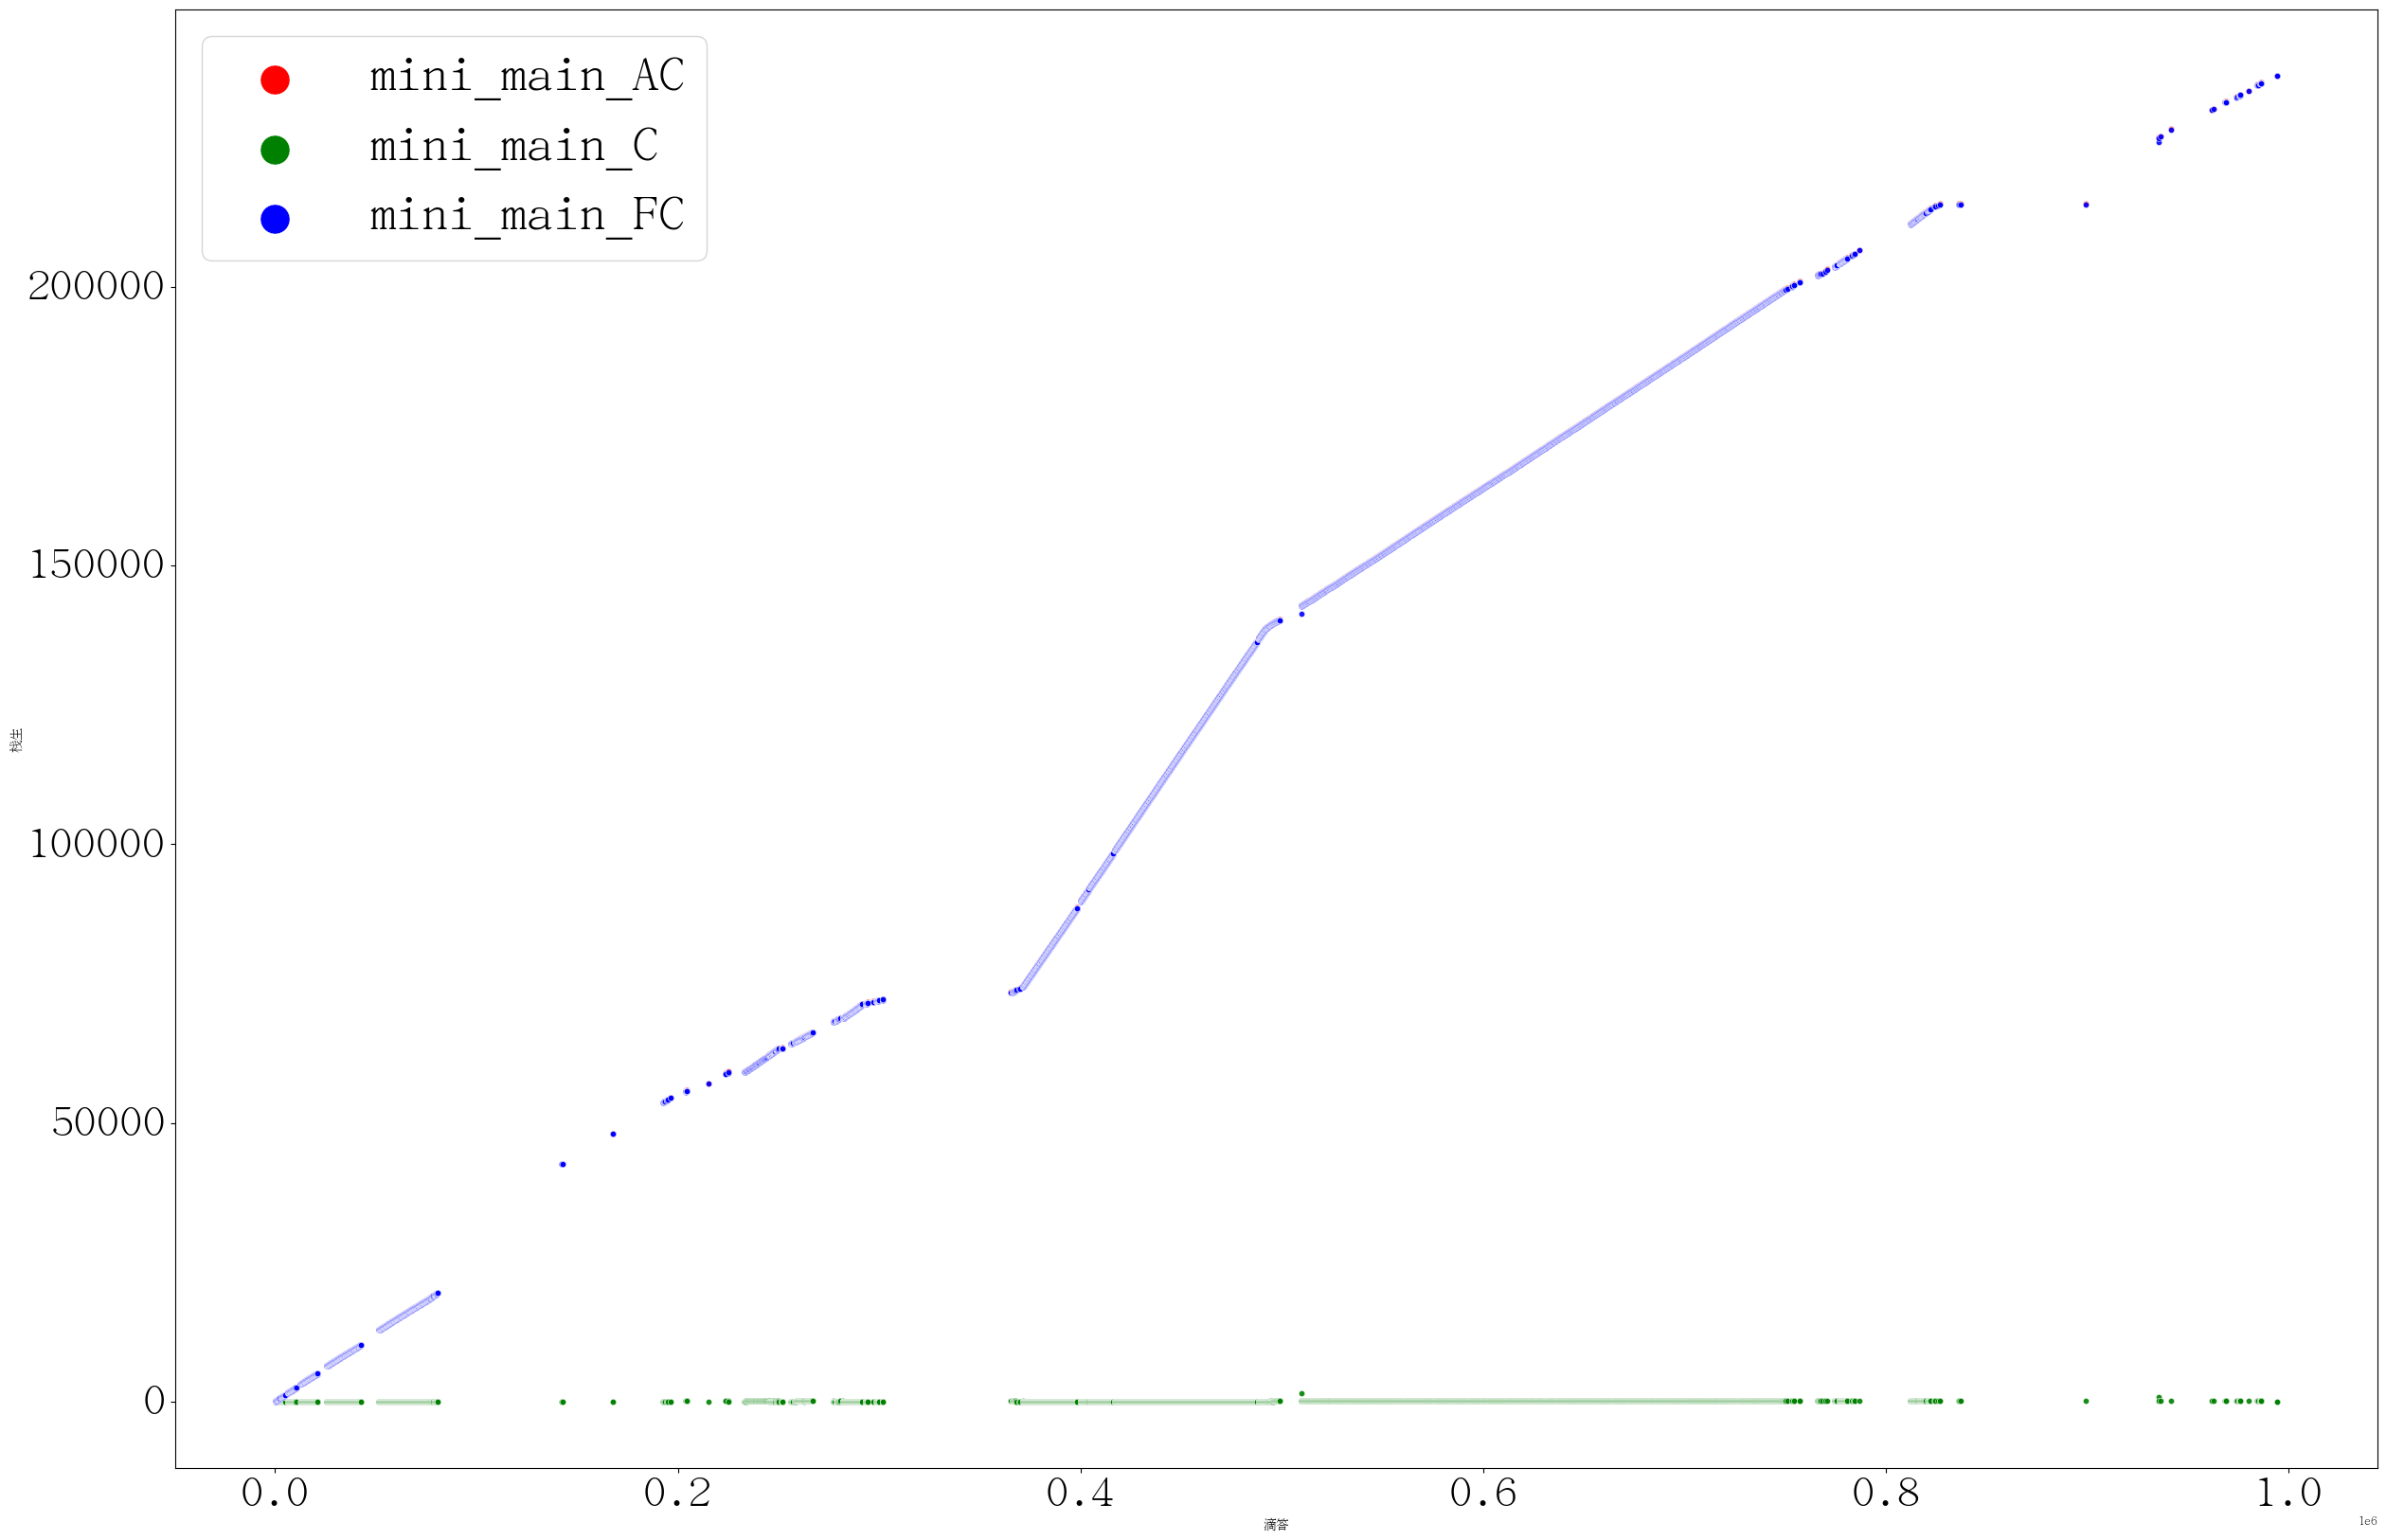

In [38]:

fig, ax = matplotlib.pyplot.subplots(figsize=(30,20))

ax.tick_params(axis='x', labelsize=35)
ax.tick_params(axis='y', labelsize=35)
matplotlib.pyplot.rcParams['font.size'] = 40

g1=seaborn.scatterplot(x='滴答', y='栈生' , data=df进出, alpha=0.9, s=20, label='mini_main_AC',color='red',ax=ax)  
g2=seaborn.scatterplot(x='滴答', y='栈净' , data=df进出, alpha=0.9, s=20, label='mini_main_C',color='green',ax=ax)   
g3=seaborn.scatterplot(x='滴答', y='栈死' , data=df进出, alpha=0.9, s=20, label='mini_main_FC',color='blue',ax=ax)   

inrease_g_size(g1)
inrease_g_size(g2)
inrease_g_size(g3)

###  栈净、链长

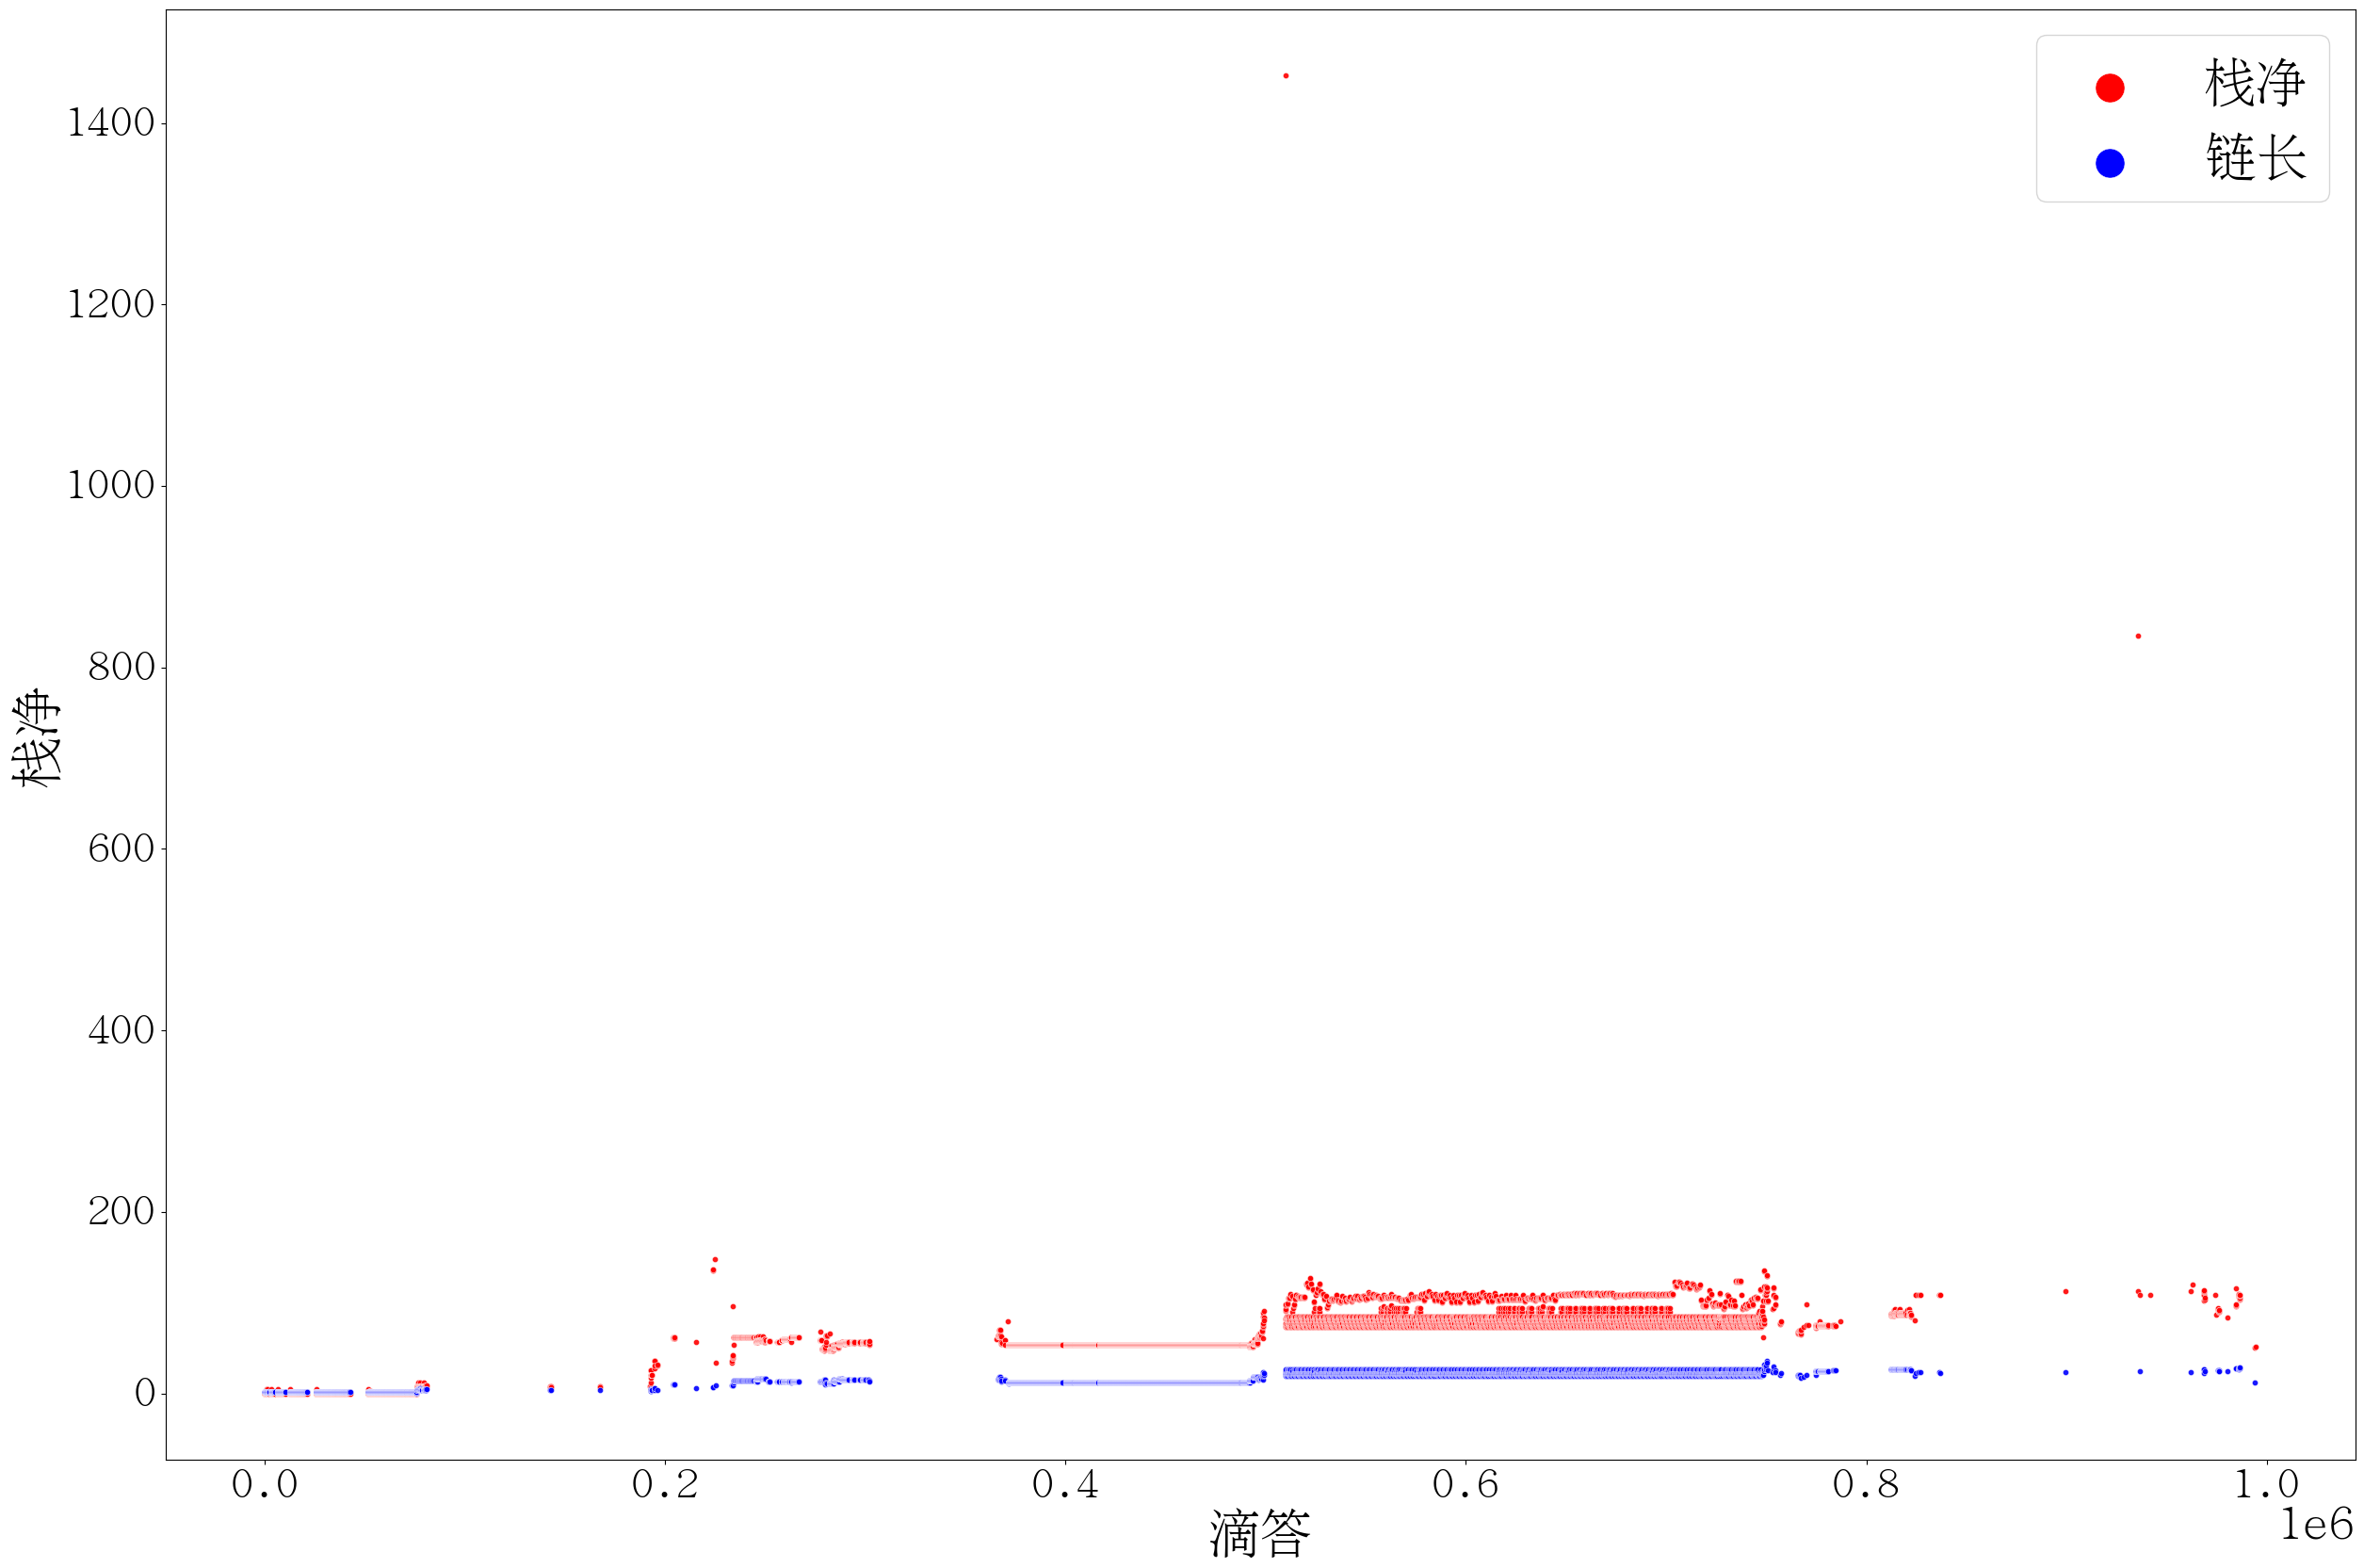

In [39]:
fig, ax = matplotlib.pyplot.subplots(figsize=(30,20))

ax.tick_params(axis='x', labelsize=35)
ax.tick_params(axis='y', labelsize=35)
matplotlib.pyplot.rcParams['font.size'] = 40

g1=seaborn.scatterplot(x='滴答', y='栈净' , data=df进出, alpha=0.9, s=20, label='栈净',color='red',ax=ax)  
g1=seaborn.scatterplot(x='滴答', y='funcEnterIdSeqLen' , data=df链, alpha=0.9, s=20, label='链长',color='blue',ax=ax)  

inrease_g_size(g1)

###  栈净对数、链长

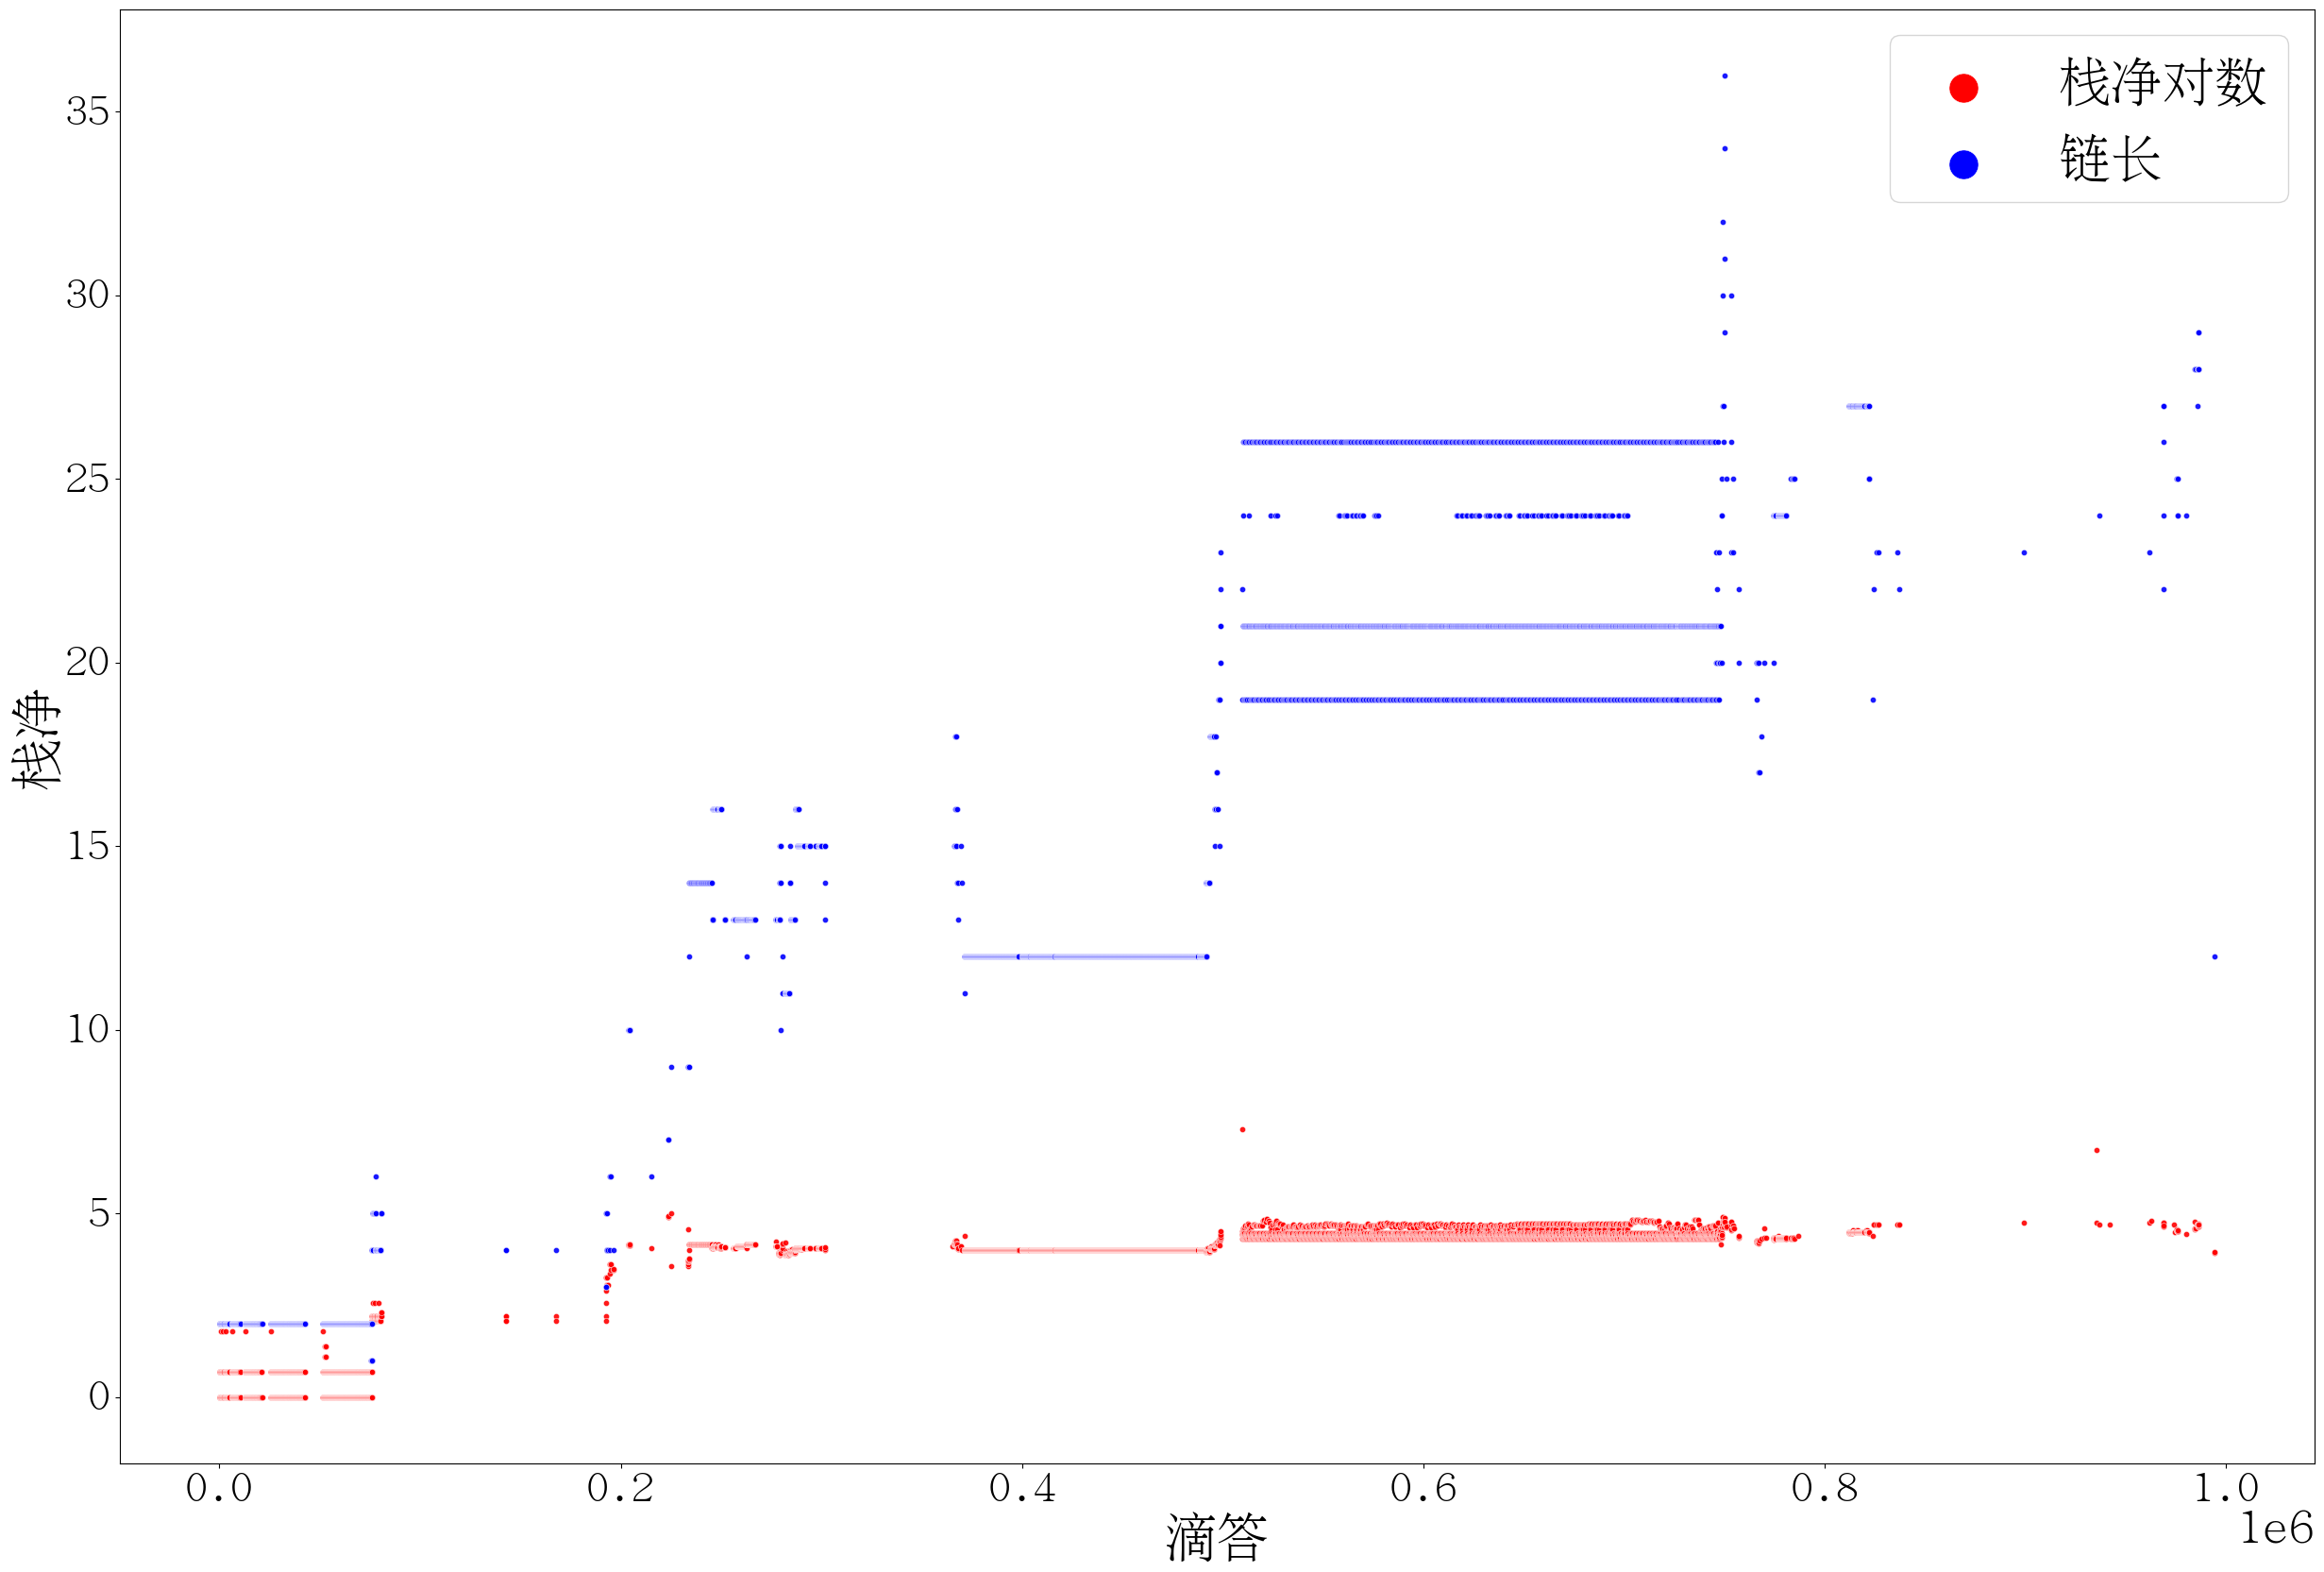

In [40]:
fig, ax = matplotlib.pyplot.subplots(figsize=(30,20))

ax.tick_params(axis='x', labelsize=35)
ax.tick_params(axis='y', labelsize=35)
matplotlib.pyplot.rcParams['font.size'] = 40

g1=seaborn.scatterplot(x='滴答', y=numpy.log(df进出['栈净']+1) , data=df进出, alpha=0.9, s=20, label='栈净对数',color='red',ax=ax)  
g1=seaborn.scatterplot(x='滴答', y='funcEnterIdSeqLen' , data=df链, alpha=0.9, s=20, label='链长',color='blue',ax=ax)  
inrease_g_size(g1)

###  栈净对数、链长折线

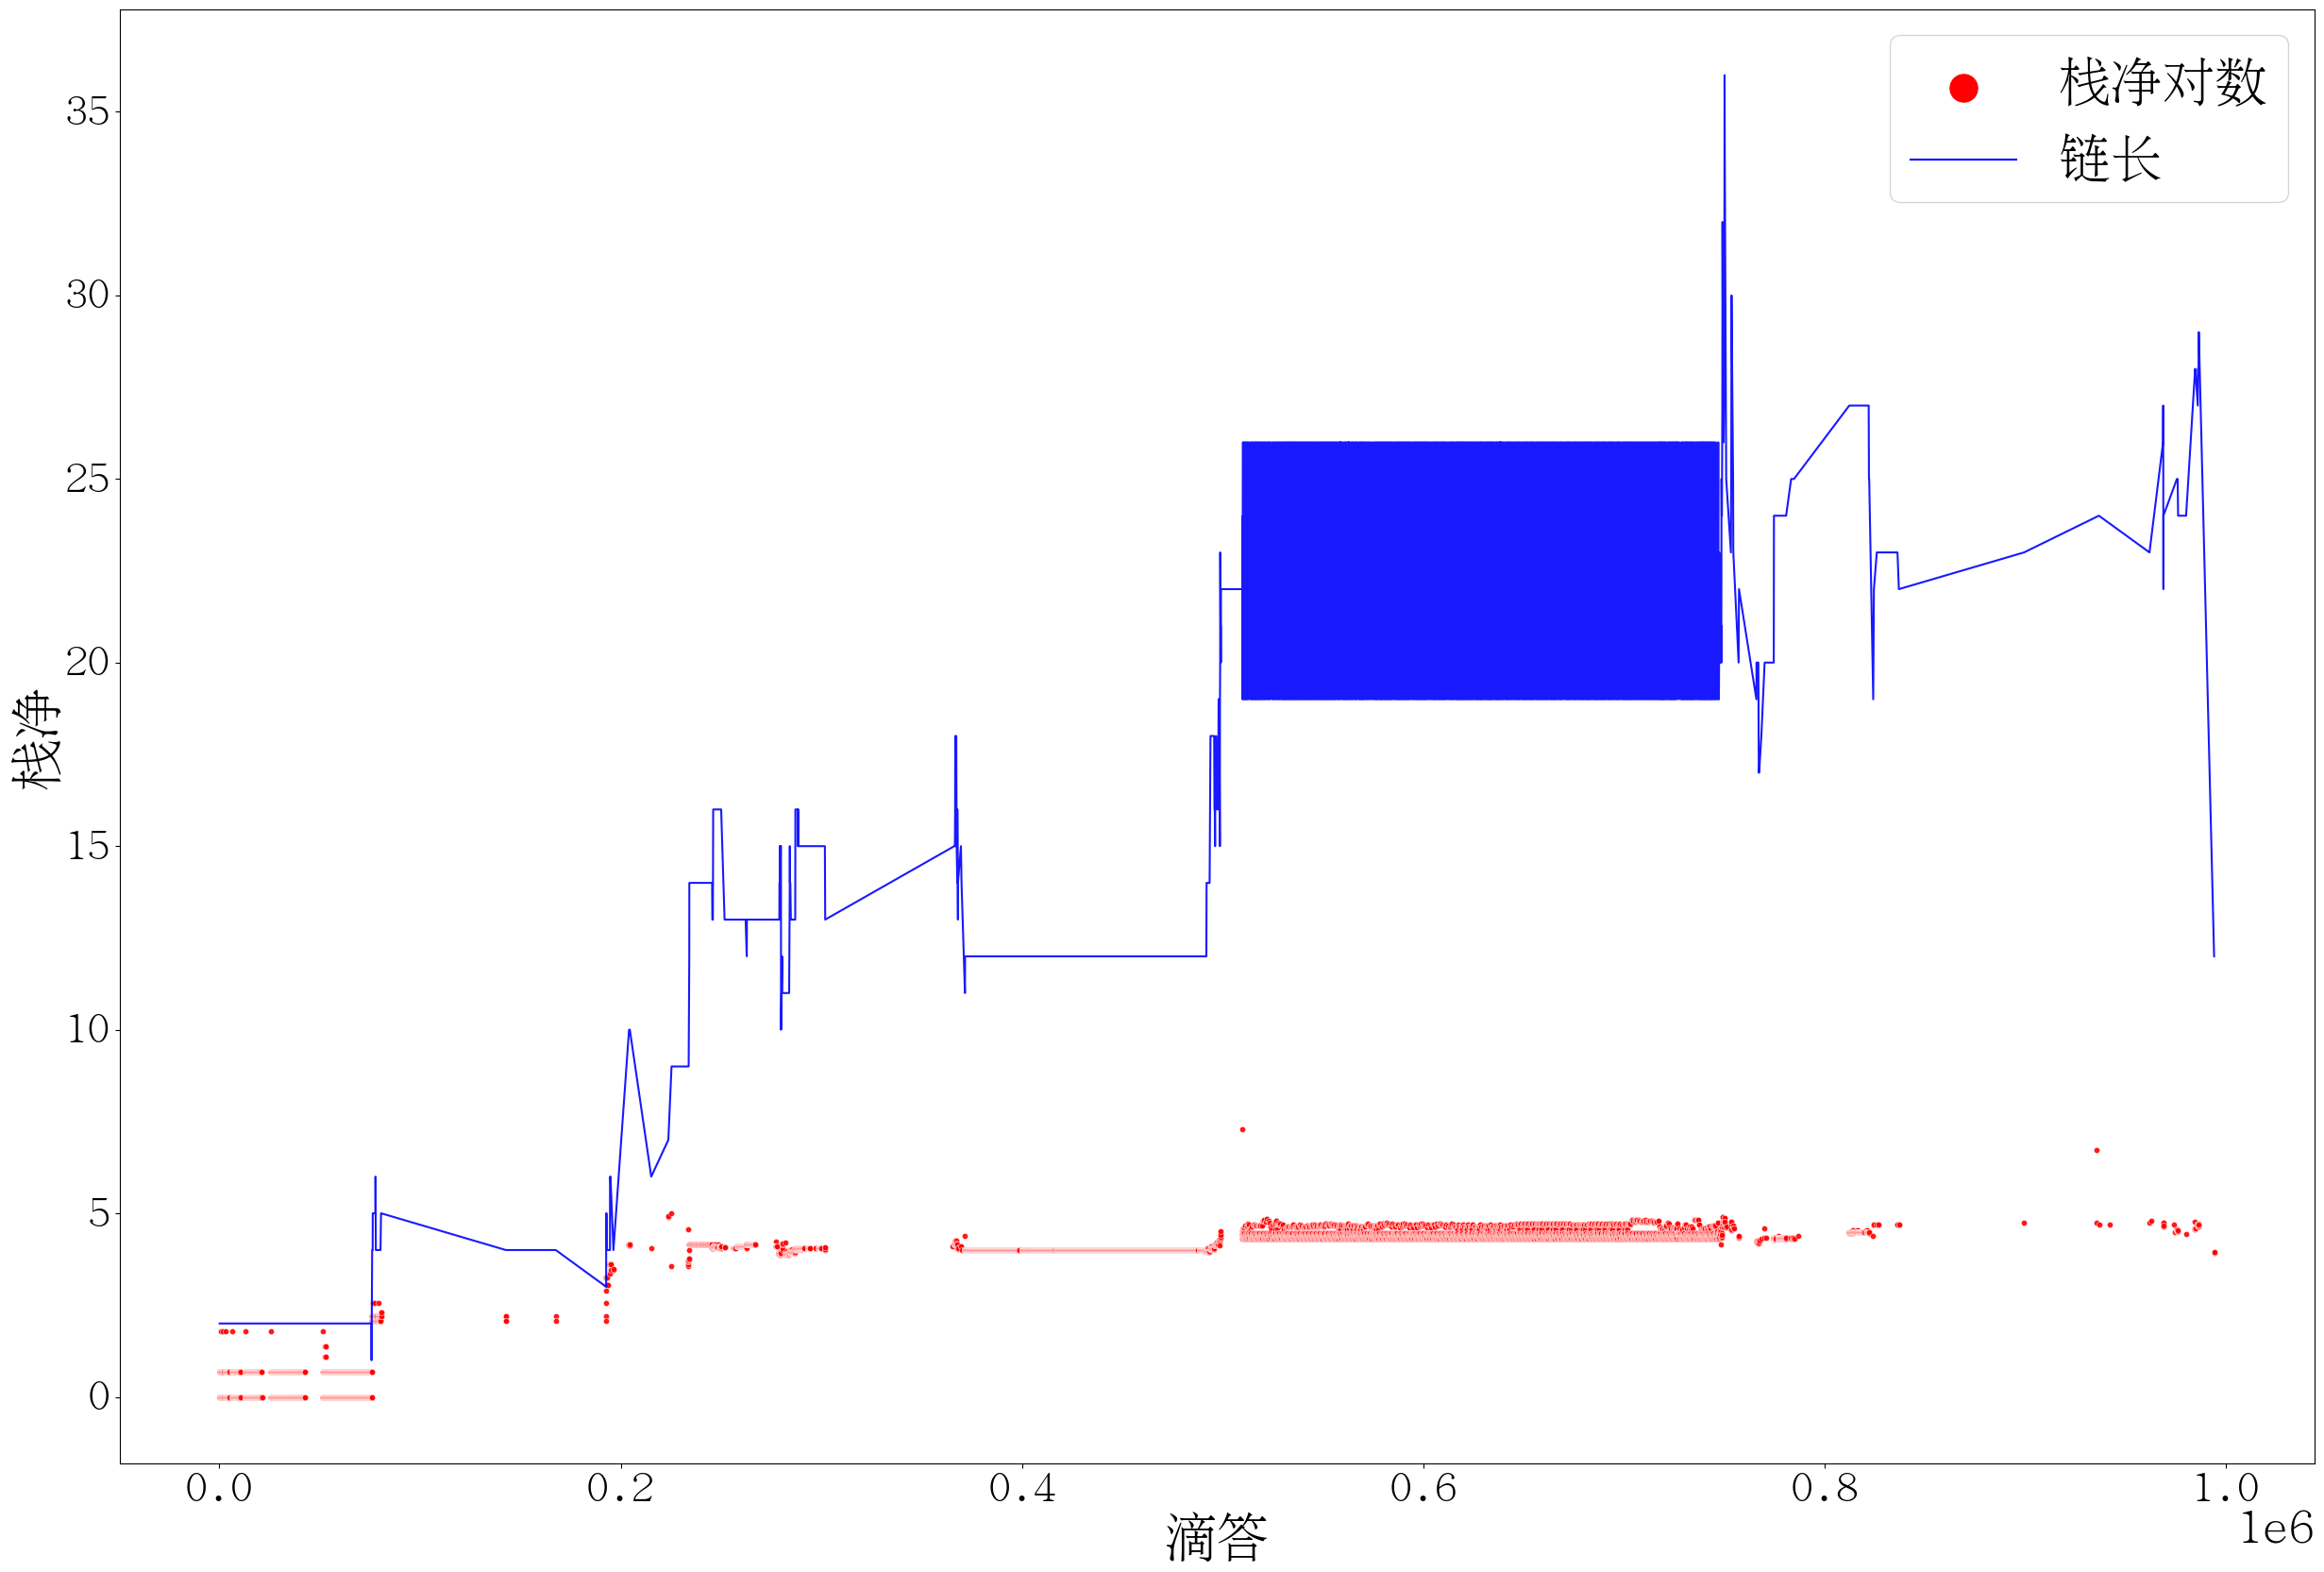

In [41]:
fig, ax = matplotlib.pyplot.subplots(figsize=(30,20))

ax.tick_params(axis='x', labelsize=35)
ax.tick_params(axis='y', labelsize=35)
matplotlib.pyplot.rcParams['font.size'] = 40

g1=seaborn.scatterplot(x='滴答', y=numpy.log(df进出['栈净']+1) , data=df进出, alpha=0.9, s=20, label='栈净对数',color='red',ax=ax)  
g1=seaborn.lineplot(x=df链.滴答, y=df链.funcEnterIdSeqLen, alpha=0.9,  label='链长',color='blue',ax=ax)  

inrease_g_size(g1)

###  栈净

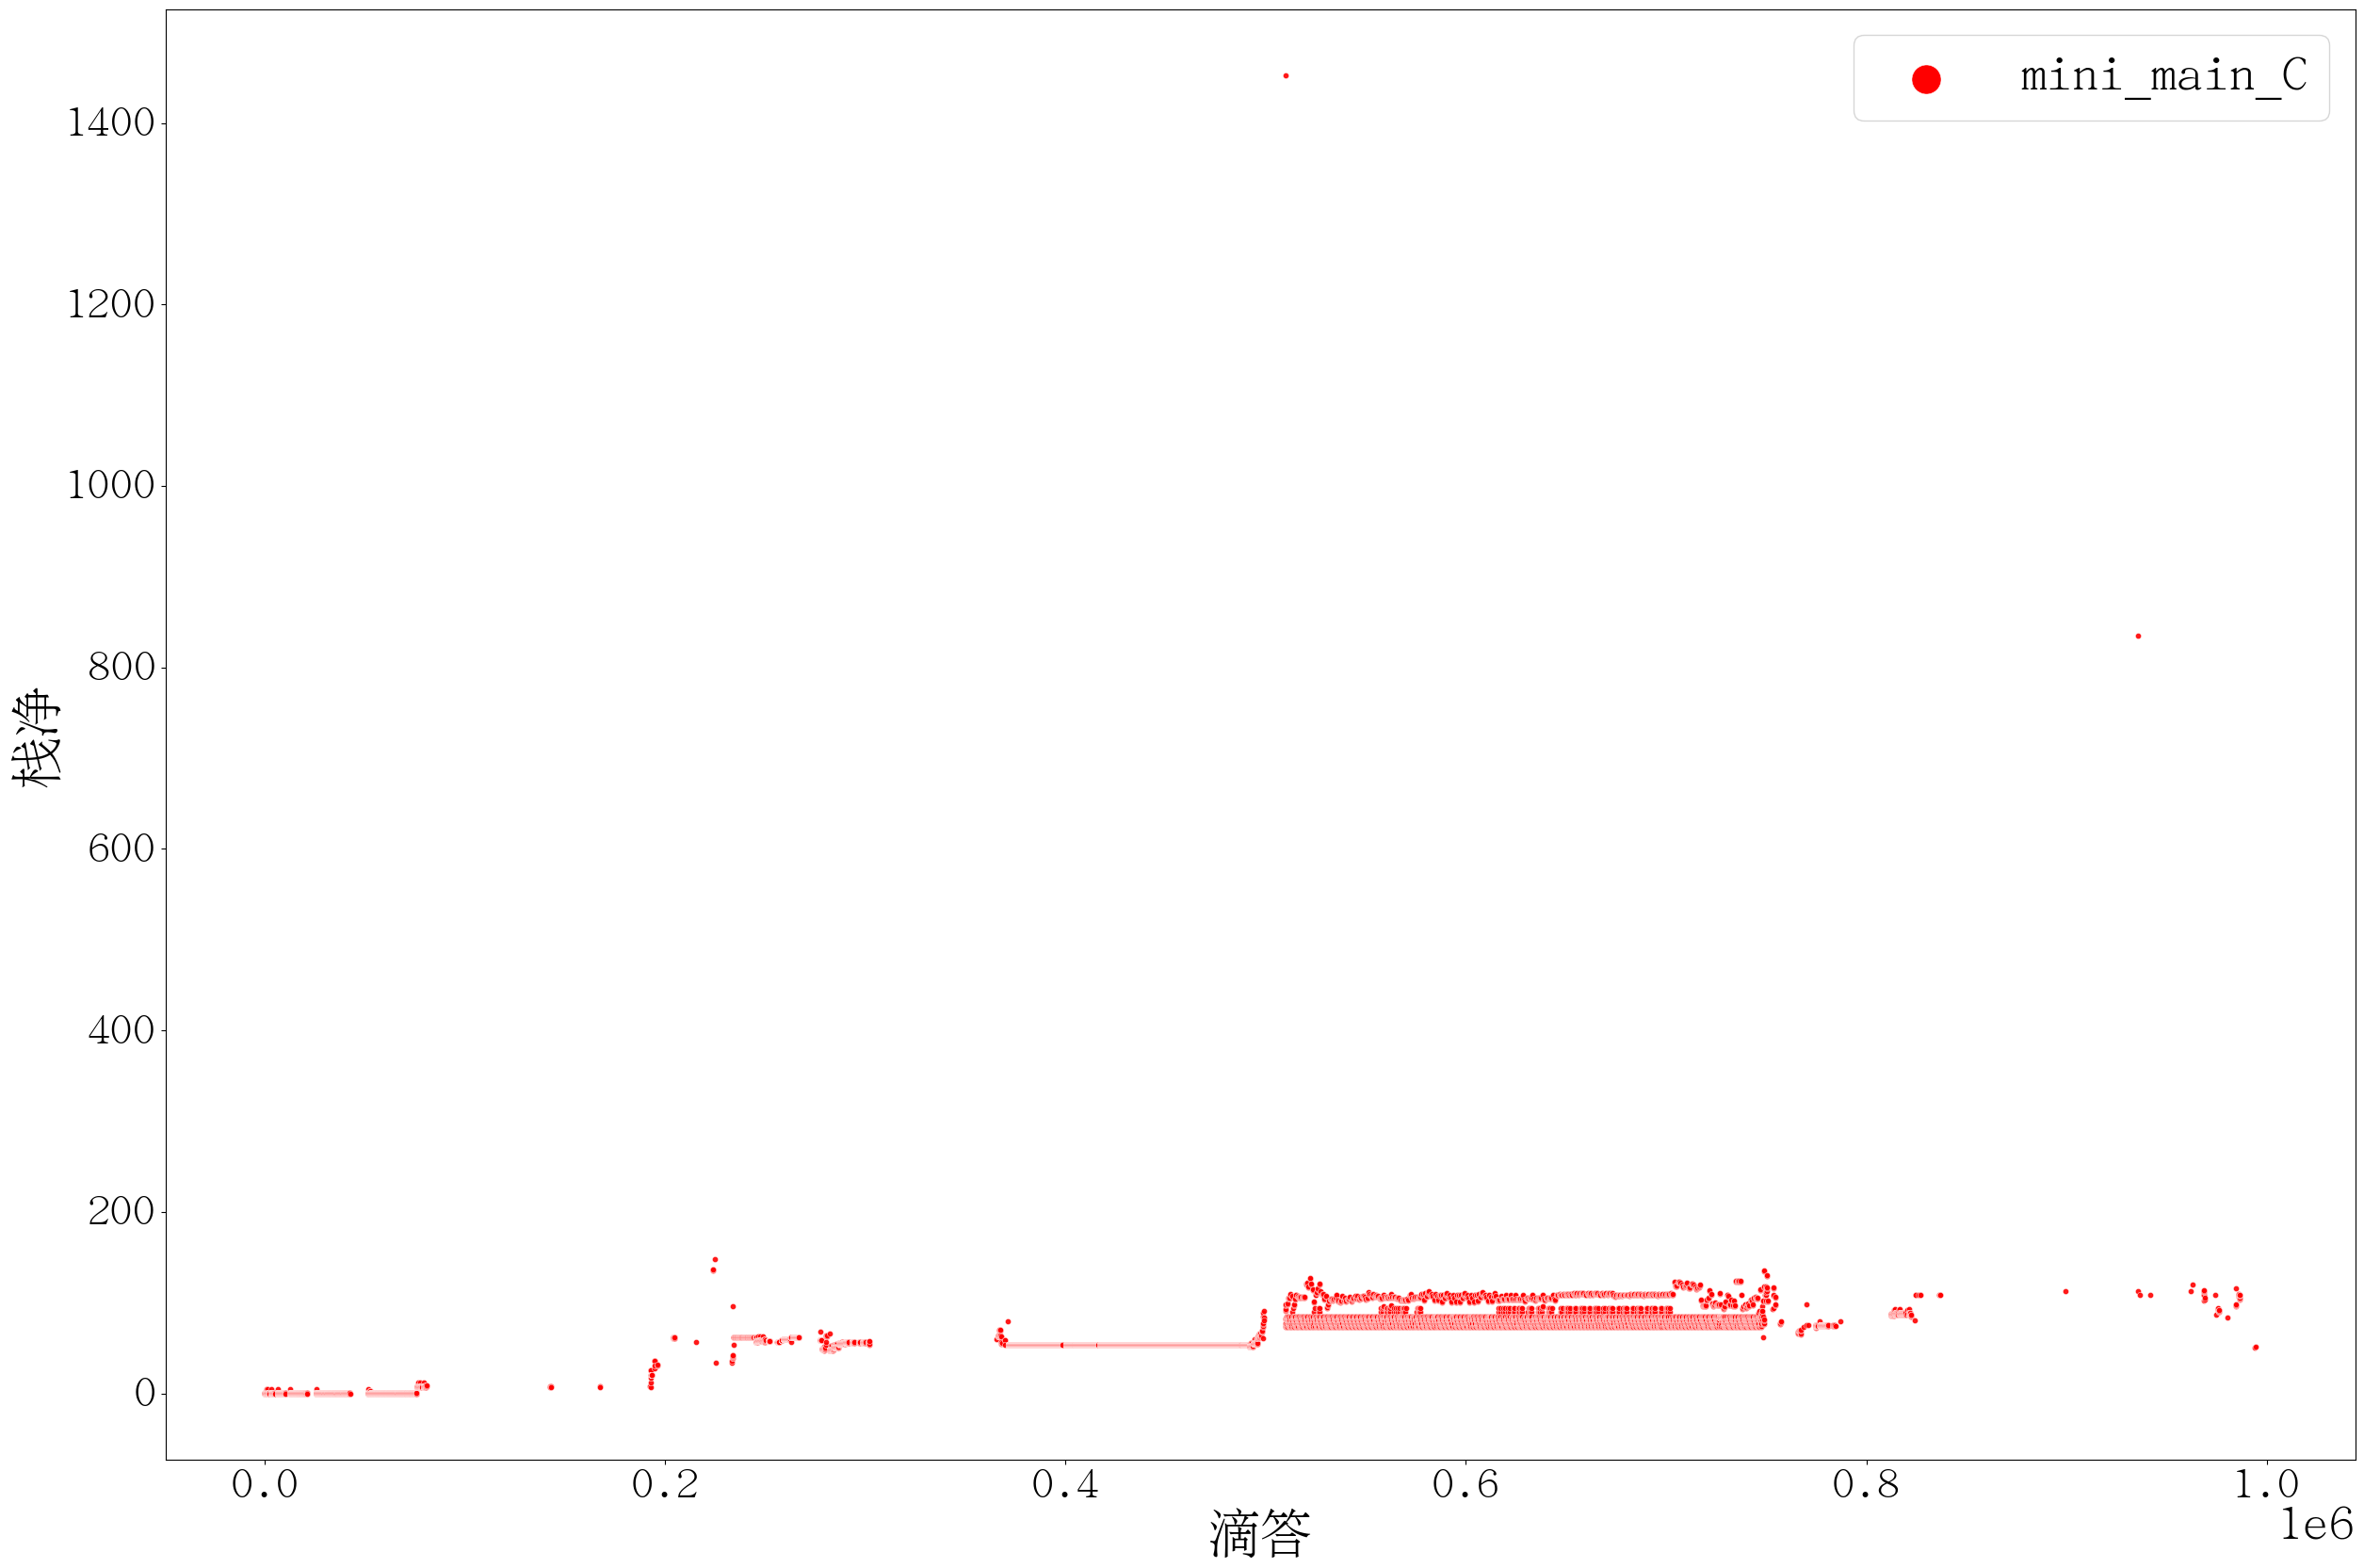

In [42]:
fig, ax = matplotlib.pyplot.subplots(figsize=(30,20))

ax.tick_params(axis='x', labelsize=35)
ax.tick_params(axis='y', labelsize=35)
matplotlib.pyplot.rcParams['font.size'] = 40

g1=seaborn.scatterplot(x='滴答', y='栈净' , data=df进出, alpha=0.9, s=20, label='mini_main_C',color='red',ax=ax)  

inrease_g_size(g1)

###  链长

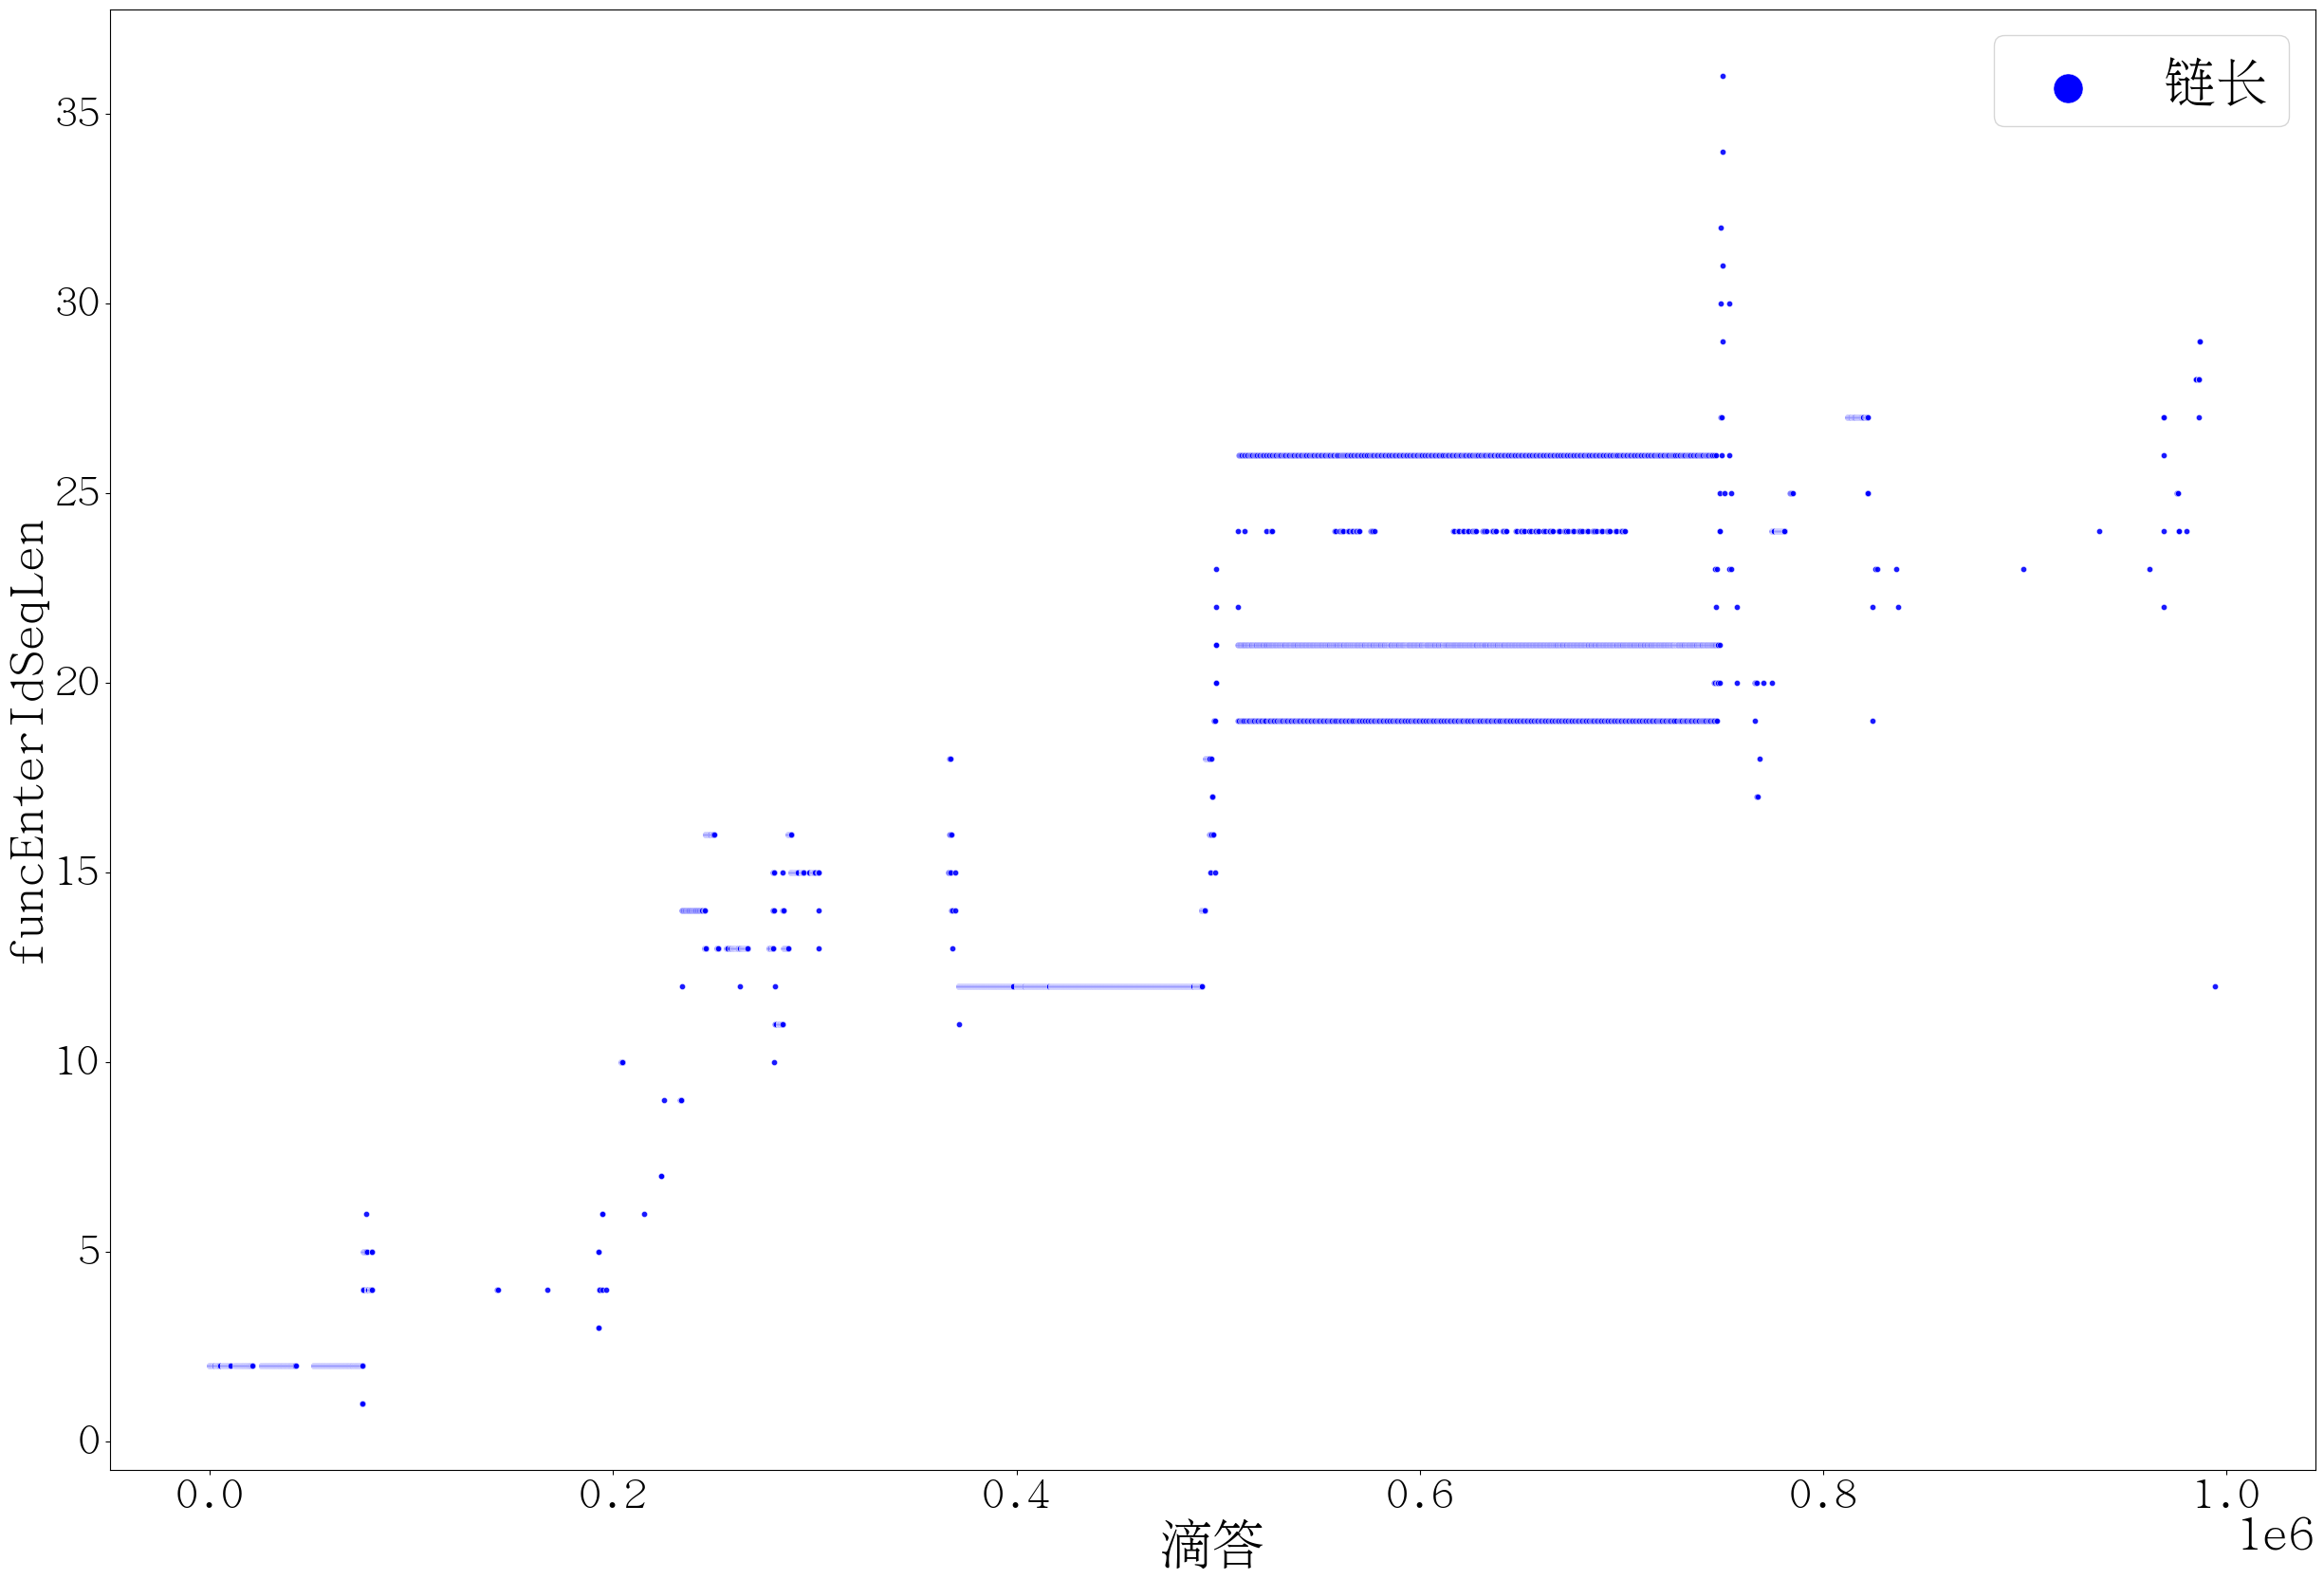

In [43]:
fig, ax = matplotlib.pyplot.subplots(figsize=(30,20))

ax.tick_params(axis='x', labelsize=35)
ax.tick_params(axis='y', labelsize=35)
matplotlib.pyplot.rcParams['font.size'] = 40

g1=seaborn.scatterplot(x='滴答', y='funcEnterIdSeqLen' , data=df链, alpha=0.9, s=20, label='链长',color='blue',ax=ax)  

inrease_g_size(g1)

##  打印长时函数、短时函数列表

In [44]:
时长边界

200

In [45]:
list( df[df.funcId.isin(本地时长funId们)].funcName.unique() )

['llvm::StringMapImpl::RehashTable',
 'llvm::opt::OptTable::OptTable',
 'llvm::opt::OptTable::addValues',
 'llvm::cl::ExpandResponseFiles',
 'llvm::opt::OptTable::ParseArgs',
 'isInput',
 'normalizeSimpleFlag',
 'clang::driver::tools::Clang::ConstructJob',
 'shouldEnableVectorizerAtOLevel',
 '(anonymous namespace)::CommandLineParser::ResetAllOptionOccurrences',
 'clang::CompilerInvocation::ParseCodeGenArgs',
 '(anonymous namespace)::CommandLineParser::ParseCommandLineOptions',
 'InitializePredefinedMacros',
 'clang::SourceManager::createFileID',
 'clang::SourceManager::getOrCreateContentCache',
 'llvm::DataLayout::parseSpecifier',
 'clang::Builtin::Context::initializeBuiltins',
 'clang::Lexer::Lexer',
 'clang::Preprocessor::Lex',
 'clang::Lexer::LexStringLiteral',
 'clang::SourceManager::getPresumedLoc',
 'clang::SrcMgr::LineOffsetMapping::get',
 'llvm::X86_MC::initLLVMToSEHAndCVRegMapping',
 'llvm::FPPassManager::runOnFunction',
 'llvm::TargetLoweringBase::initActions',
 'llvm::Target

In [46]:
list ( df[df.funcId.isin(本地时短funId们)].funcName.unique() )
#仔细看，会发现有很多 ::get* 函数， 这种命名显然是函数代码内容很短，所有说他们执行时间短 是有道理的

['llvm::cl::getGeneralCategory',
 'llvm::cl::OptionCategory::registerCategory',
 'llvm::ManagedStaticBase::RegisterManagedStatic',
 'llvm::llvm_is_multithreaded',
 'getManagedStaticMutex',
 'llvm::cl::Option::setArgStr',
 'llvm::cl::Option::addArgument',
 'llvm::StringMapImpl::LookupBucketFor',
 'llvm::StringMapImpl::init',
 'createTable',
 'getHashTable',
 'llvm::allocate_buffer',
 'llvm::RegisterBank::RegisterBank',
 'llvm::cl::AddLiteralOption',
 'llvm::SmallVectorBase::grow_pod',
 'getNewCapacity',
 'llvm::DebugCounter::instance',
 'llvm::BranchProbability::BranchProbability',
 'llvm::MCFragment::MCFragment',
 'llvm::PassRegistry::getPassRegistry',
 'llvm::PassRegistry::registerPass',
 'llvm::Regex::Regex',
 'readRequiredParams',
 'clang::ento::CallDescription::CallDescription',
 '(anonymous namespace)::getExpectedProducerName',
 '(anonymous namespace)::SegmentInjection::SegmentInjection',
 'clang_main',
 'clang::noteBottomOfStack',
 'getStackPointer',
 'llvm::InitLLVM::InitLLVM',
